In [1]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
import numpy as np
from random import random
from numpy import zeros, ones, asarray, load, vstack, savez_compressed
from numpy.random import randint 
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Input, Embedding, Concatenate, BatchNormalization, Activation
from matplotlib import pyplot as plt 
from tensorflow.keras.utils import plot_model
from os import listdir
from keras.preprocessing.image import img_to_array, load_img
from datetime import datetime
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from sklearn.utils import resample

In [3]:
def Discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    
    in_image = Input(shape=image_shape)
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    patch_out = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    
    model = Model(in_image, patch_out)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model 

discriminator = Discriminator(image_shape=(256, 256, 3))
print(discriminator.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 instance_normalization (Ins  (None, 64, 64, 128)      256       
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                             

In [4]:
def residual_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02)
    
    g = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])
    return g

In [5]:
def Generator(image_shape, n_residual_block=9):
    init = RandomNormal(stddev=0.02)
    
    in_image = Input(shape=image_shape)
    g = Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    for _ in range(n_residual_block):
        g = residual_block(256, g)
    
    g = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    
    model = Model(in_image, out_image)
    return model

generator = Generator(image_shape=(256, 256, 3))
print(generator.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization_4 (Inst  (None, 256, 256, 64  128        ['conv2d_6[0][0]']               
 anceNormalization)             )                                                           

                                                                                                  
 instance_normalization_13 (Ins  (None, 64, 64, 256)  512        ['conv2d_15[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 activation_6 (Activation)      (None, 64, 64, 256)  0           ['instance_normalization_13[0][0]
                                                                 ']                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 256)  590080      ['activation_6[0][0]']           
                                                                                                  
 instance_normalization_14 (Ins  (None, 64, 64, 256)  512        ['conv2d_16[0][0]']              
 tanceNorm

                                                                                                  
 conv2d_25 (Conv2D)             (None, 64, 64, 256)  5308672     ['concatenate_7[0][0]']          
                                                                                                  
 instance_normalization_23 (Ins  (None, 64, 64, 256)  512        ['conv2d_25[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 activation_11 (Activation)     (None, 64, 64, 256)  0           ['instance_normalization_23[0][0]
                                                                 ']                               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 64, 64, 256)  590080      ['activation_11[0][0]']          
          

In [6]:
def Composite(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # adversarial loss
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity loss
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # cycle loss - forward
    output_f = g_model_2(gen1_out)
    # cycle loss - backward
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[1, 5, 10, 10])
    return model

In [7]:
def generate_real_samples(dataset, n_samples, patch_shape):
    idx = randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

def save_models(step, g_model_AtoB, g_model_BtoA):
    modelpath1 = './cycleGAN_Generate/Models/g_model_AtoB_%06d.h5' % (step + 1)
    g_model_AtoB.save(modelpath1)
    modelpath2 = './cycleGAN_Generate/Models/g_model_BtoA_%06d.h5' % (step + 1)
    g_model_BtoA.save(modelpath2)
    print('Save Successfully')
    
def summarize_performance(step, g_model, train_X, name, n_samples=5):
    X_in, _ = generate_real_samples(train_X, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0 
    for i in range(n_samples):
        plt.subplot(2, n_samples, i + 1)
        plt.axis('off')
        plt.imshow(X_in[i])
    for i in range(n_samples):
        plt.subplot(2, n_samples, i + n_samples + 1)
        plt.axis('off')
        plt.imshow(X_out[i])
    imagepath = './cycleGAN_Generate/Images/%s_generated_plot_%06d.png' % (name, (step + 1))
    plt.savefig(imagepath)
    plt.close()
    
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            idx = randint(0, len(pool))
            selected.append(pool[idx])
            pool[idx] = image
    return asarray(selected)

In [8]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=50):
    n_epochs, n_batch = epochs, 1
    n_patch = d_model_A.output_shape[1]
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    batch_per_epoch = int(len(trainA) / n_batch)
    n_steps = batch_per_epoch * n_epochs
    
    for i in range(n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i + 1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))
        
        if (i + 1) % 30 == 0:
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
            save_models(i, g_model_AtoB, g_model_BtoA)

In [9]:
def load_images(path, size=(256, 256)):
    data_list = list()
    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    return asarray(data_list)

path = './monet2photo/'

dataA = resample(load_images(path + 'trainA/'), replace=False, n_samples=300, random_state=42)
print('Loaded dataA: ', dataA.shape)
dataB = resample(load_images(path + 'trainB/'), replace=False, n_samples=300, random_state=42)
print('Loaded dataB: ', dataB.shape)

Loaded dataA:  (300, 256, 256, 3)
Loaded dataB:  (300, 256, 256, 3)


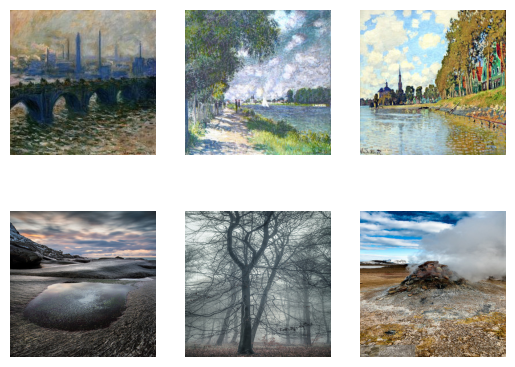

In [10]:
n_samples = 3 

for i in range(n_samples):
    plt.subplot(2, n_samples, i + 1)
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
    
for i in range(n_samples):
    plt.subplot(2, n_samples, i + n_samples + 1)
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
    
plt.show()

In [12]:
data = [dataA, dataB]

def preprocessing_data(data):
    X1, X2 = data[0], data[1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocessing_data(data)

image_shape = dataset[0].shape[1:]
g_model_AtoB = Generator(image_shape)
g_model_BtoA = Generator(image_shape)
d_model_A = Discriminator(image_shape)
d_model_B = Discriminator(image_shape)
c_model_AtoB = Composite(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = Composite(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

start = datetime.now()
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=5)
stop = datetime.now()

execution_time = stop - start 
print("Execution time is: ", execution_time)

Iteration>1, dA[1.331,0.878] dB[3.283,0.973] g[23.114,18.714]
Iteration>2, dA[4.208,1.564] dB[5.472,0.687] g[20.222,19.669]
Iteration>3, dA[6.813,4.728] dB[2.893,0.975] g[18.366,17.973]
Iteration>4, dA[2.878,2.698] dB[2.800,2.024] g[15.724,15.798]
Iteration>5, dA[3.288,1.606] dB[3.177,1.715] g[16.459,27.832]
Iteration>6, dA[2.322,1.624] dB[4.111,2.081] g[18.086,17.754]
Iteration>7, dA[1.481,1.267] dB[1.996,1.623] g[16.327,17.373]
Iteration>8, dA[1.935,1.355] dB[2.239,1.768] g[16.739,16.489]
Iteration>9, dA[1.047,1.242] dB[2.986,2.909] g[14.553,13.090]
Iteration>10, dA[1.042,1.047] dB[2.419,3.334] g[12.572,10.816]
Iteration>11, dA[0.694,3.446] dB[3.938,2.000] g[20.929,20.559]
Iteration>12, dA[1.031,2.498] dB[2.749,1.354] g[15.175,14.738]
Iteration>13, dA[0.760,1.415] dB[0.851,1.222] g[16.726,16.015]
Iteration>14, dA[0.716,0.963] dB[0.678,1.007] g[14.873,15.181]
Iteration>15, dA[0.689,0.895] dB[1.259,1.170] g[12.467,11.967]
Iteration>16, dA[0.688,0.548] dB[0.842,1.101] g[13.099,11.987]
I

NameError: name 'random' is not defined

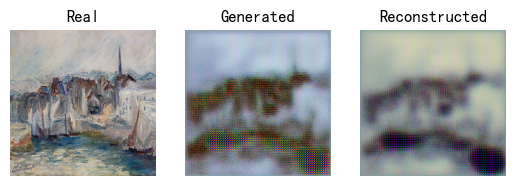

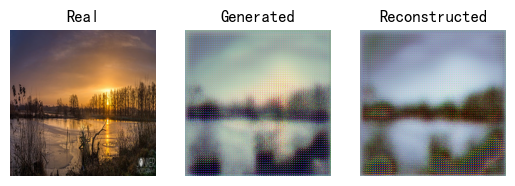

In [14]:
def select_sample(dataset, n_samples):
    idx = randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    return X

def plot_show(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    images = (images + 1) / 2.0 
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

testA = resample(dataA, replace=False, n_samples=10, random_state=42)
testB = resample(dataB, replace=False, n_samples=10, random_state=42)

testA = (testA - 127.5) / 127.5
testB = (testB - 127.5) / 127.5

cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('./cycleGAN_Generate/Models/g_model_AtoB_000030.h5', cust, compile=False)
model_BtoA = load_model('./cycleGAN_Generate/Models/g_model_BtoA_000030.h5', cust, compile=False)

A_real = select_sample(testA, 1)
B_generated = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
plot_show(A_real, B_generated, A_reconstructed)

B_real = select_sample(testB, 1)
A_generated = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
plot_show(B_real, A_generated, B_reconstructed)